# 4.1/2 Defensive statistics & Defensive style

In [1]:
%load_ext autoreload
%autoreload 2

# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
import zipfile
from pathlib import Path
import os
import sys
from IPython.display import display

# specfic soccer analysis packages
from mplsoccer import Pitch, Sbopen, VerticalPitch

# load custom functions
from src.visualization import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Individual games

In [48]:
match_id = "5414203"
df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)

In [49]:
team2 = 'Northern Ireland'
team1 = 'Slovenia'
title = 'EM Qualifier: 2023-09-07 (2:4)'

### Defensive statistics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


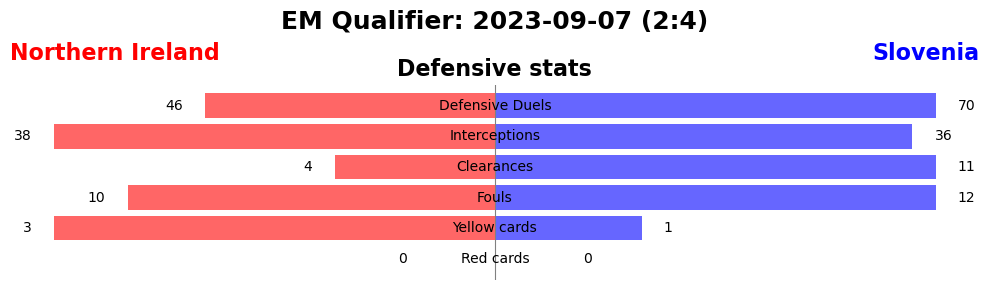

In [50]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)

team2_data = {'Defensive Duels': df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team2)]["groundDuel.relatedDuelId"].notna().sum(),
            'Interceptions': team_type_counts.loc[team2, 'interception'],
            'Clearances': team_type_counts.loc[team2, 'clearance'],
            'Fouls': team_type_counts.loc[team2, 'infraction'],
            'Yellow cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0],
            'Red cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0],
            }

team1_data = {'Defensive Duels': df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team1)]["groundDuel.relatedDuelId"].notna().sum(),
            'Interceptions': team_type_counts.loc[team1, 'interception'],
            'Clearances': team_type_counts.loc[team1, 'clearance'],
            'Fouls': team_type_counts.loc[team1, 'infraction'],
            'Yellow cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0],
            'Red cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0],
            }

perc_categories = []

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive stats', team1_color='blue', team2_color='red',saveplt=True, savepath=f'plots/4-defense/defense_statistics_{match_id}.png')

### Defensive style and efficiency

In [117]:
def calculate_defensive_efficiency(team_name, opponent_name, num_matches=1):

    team_events = df_events[df_events["team.name"] == team_name]
    
    defensive_duels = team_events[(team_events["groundDuel.duelType"] == "defensive_duel")]
    defensive_duels_ownthird = defensive_duels[(defensive_duels["location.x"] < 33.3)]
    duels_won = defensive_duels[(defensive_duels["groundDuel.stoppedProgress"] == True) | (defensive_duels["groundDuel.recoveredPossession"] == True)].shape[0]
    duels_won_pos = defensive_duels[(defensive_duels["groundDuel.recoveredPossession"] == True)].shape[0]
    duels_won_ownthird = defensive_duels_ownthird[(defensive_duels_ownthird["groundDuel.stoppedProgress"] == True) | (defensive_duels_ownthird["groundDuel.recoveredPossession"] == True)].shape[0]
    total_events = defensive_duels.shape[0]
    total_events_ownthird = defensive_duels_ownthird.shape[0]

    # ball recovery time avg possession duration of opponent
    ball_recovery_time = df_events[(df_events["possession.team.name"] == opponent_name)]["possession.duration"].mean()

    # defensive errors = interceptions + offensive duels lost + dribbles lost in own half
    own_half = df_events[(df_events["location.x"] < 50)]
    interceptions = own_half[(own_half["type.primary"] == "interception") & (own_half["team.name"] == opponent_name)]
    offensive_duels_lost = own_half[(own_half["groundDuel.duelType"] == "offensive_duel") & (own_half["team.name"] == team_name) & (own_half["groundDuel.keptPossession"] == False)]
    dribbles_lost = own_half[(own_half["groundDuel.duelType"] == "offensive_duel") & (own_half["team.name"] == team_name) & (own_half["groundDuel.keptPossession"] == False)]
    defensive_errors = pd.concat([interceptions, offensive_duels_lost, dribbles_lost]).shape[0]

    # Pressure actions
    interceptions = team_events[(team_events["type.primary"] == "interception")]
    clearence = team_events[(team_events["type.primary"] == "clearance")]
    defensive_duels = team_events[(team_events["groundDuel.duelType"] == "defensive_duel")]
    pressures = pd.concat([interceptions, clearence, defensive_duels])

    # High press: Pressure in the opposing third
    high_press = pressures[(pressures["location.x"] > 66.6)]
    mid_press = pressures[(pressures["location.x"] > 33.3) & (pressures["location.x"] < 66.6)]
    low_press = pressures[(pressures["location.x"] < 33.3)]

    return {'Duels Won': round(duels_won / total_events, 2),
            'Duels Won Own Third': round(duels_won_ownthird / total_events_ownthird, 2),
            'Duels Gained Possession': round(duels_won_pos / total_events, 2),
            'Ball Recovery Time': round(ball_recovery_time, 2),
            'Defensive Errors': int(defensive_errors / num_matches),
            'High Press': round(high_press.shape[0] / pressures.shape[0], 2),
            'Mid Press': round(mid_press.shape[0] / pressures.shape[0], 2),
            'Low Press': round(low_press.shape[0] / pressures.shape[0], 2),
            }


In [ ]:
# Use the function to calculate stats for Denmark and Slovenia
team2_data = calculate_defensive_efficiency(team2, team1)
team1_data = calculate_defensive_efficiency(team1, team2)

perc_categories = ["Duels Won", "Duels Won Own Third", "Duels Gained Possession", "High Press", "Mid Press", "Low Press"]

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive Efficiency & Style', team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/4-defense/defensive_efficiency_style_{match_id}.png')

## DEN vs SVN aggregate

In [118]:
match_ids = ['5414302', '5414180']

team2 = 'Denmark'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'DEN vs SVN aggregate'
num_matches = len(match_ids)

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])


### Defensive statistics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


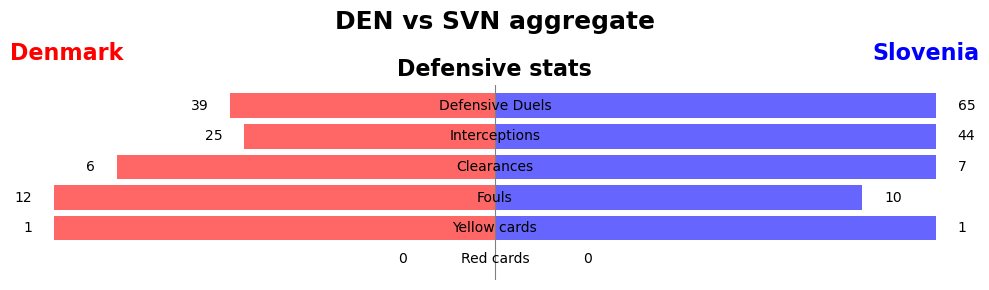

In [119]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)

team2_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team2)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team2, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team2, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team2, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

team1_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team1)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team1, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team1, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team1, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

perc_categories = []

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive stats', team1_color='blue', team2_color='red',saveplt=True, savepath=f'plots/4-defense/defense_statistics_DEN_SVN_agg.png')

### Defensive style and efficiency

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


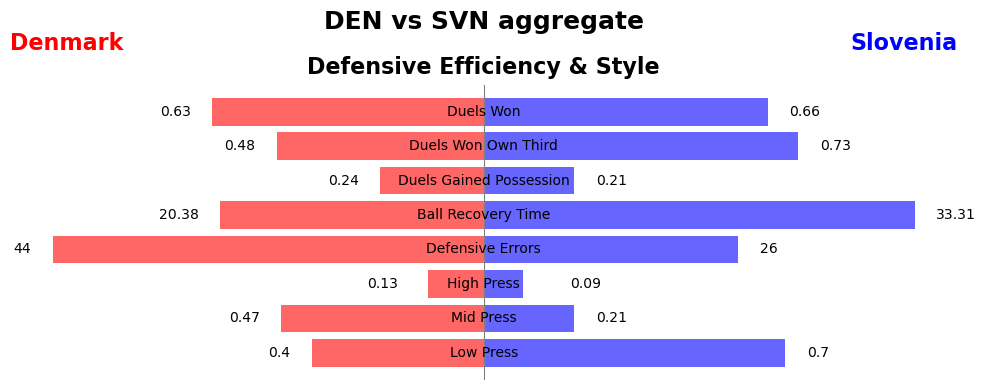

In [120]:
# Use the function to calculate stats for Denmark and Slovenia
team2_data = calculate_defensive_efficiency(team2, team1, num_matches=num_matches)
team1_data = calculate_defensive_efficiency(team1, team2, num_matches=num_matches)

perc_categories = ["Duels Won", "Duels Won Own Third", "Duels Gained Possession", "High Press", "Mid Press", "Low Press"]

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive Efficiency & Style', team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/4-defense/defensive_efficiency_style_DEN_SVN_agg.png')

## All games aggregate

In [121]:
match_ids = ['5414324', '5414302', '5414284', '5414260', '5414226', '5414180', '5414103', '5414128', '5414156', '5414203']
opponent_names = ['Denmark', 'San Marino', 'Northern Ireland', 'Finland', 'Kazakhstan']

team2 = 'Opponents'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'SVN EM Qualifiers aggregate'
num_matches = len(match_ids)

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])

# replace opponent names with 'Opponent'
df_events['team.name'] = df_events['team.name'].replace(opponent_names, team2)
df_events['possession.team.name'] = df_events['possession.team.name'].replace(opponent_names, team2)

### Defensive statistics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


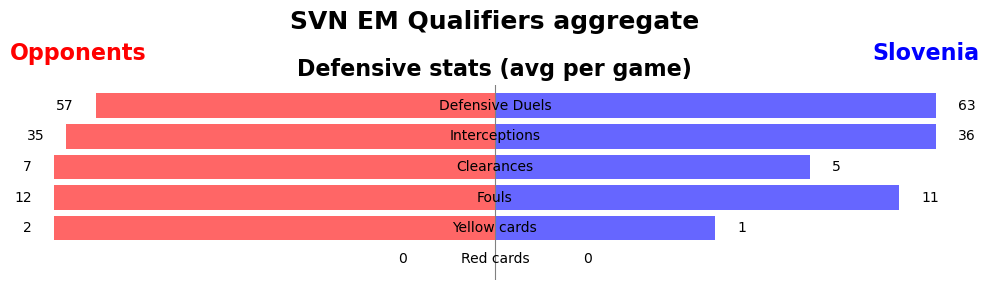

In [122]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)

team2_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team2)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team2, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team2, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team2, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

team1_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team1)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team1, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team1, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team1, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

perc_categories = []

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive stats (avg per game)', team1_color='blue', team2_color='red',saveplt=True, savepath=f'plots/4-defense/defense_statistics_SVN_agg.png')

### Defensive style and efficiency

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


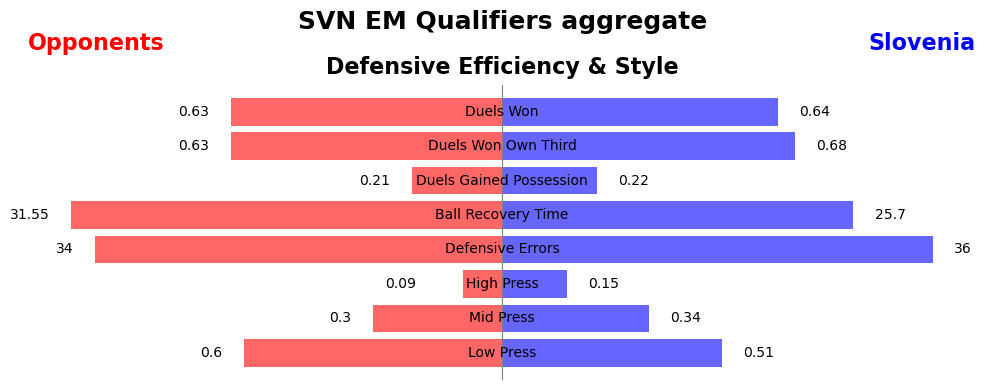

In [123]:
# Use the function to calculate stats for Denmark and Slovenia
team2_data = calculate_defensive_efficiency(team2, team1, num_matches=num_matches)
team1_data = calculate_defensive_efficiency(team1, team2, num_matches=num_matches)

perc_categories = ["Duels Won", "Duels Won Own Third", "Duels Gained Possession", "High Press", "Mid Press", "Low Press"]

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive Efficiency & Style', team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/4-defense/defensive_efficiency_style_SVN_agg.png')

## SVN vs weak teams aggregate

In [124]:
match_ids = ['5414324', '5414226', '5414103', '5414128']
opponent_names = ['San Marino', 'Kazakhstan']

team2 = 'Opponents'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'SVN vs weaker teams aggregate'
num_matches = len(match_ids)

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])

# replace opponent names with 'Opponent'
df_events['team.name'] = df_events['team.name'].replace(opponent_names, team2)
df_events['possession.team.name'] = df_events['possession.team.name'].replace(opponent_names, team2)

### Defensive statistics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


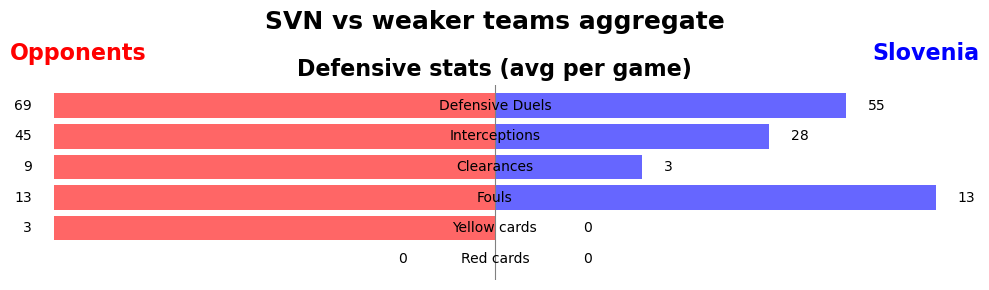

In [125]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)

team2_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team2)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team2, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team2, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team2, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

team1_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team1)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team1, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team1, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team1, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

perc_categories = []

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive stats (avg per game)', team1_color='blue', team2_color='red',saveplt=True, savepath=f'plots/4-defense/defense_statistics_SVN_vs_weak.png')

### Defensive style and efficiency

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


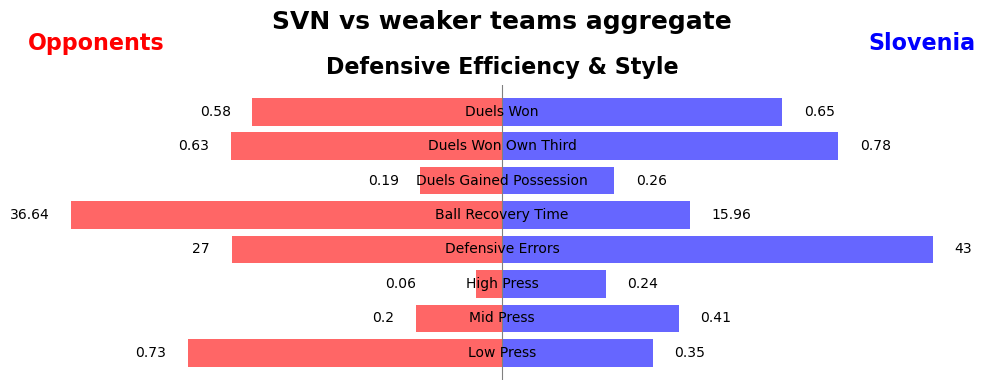

In [126]:
# Use the function to calculate stats for Denmark and Slovenia
team2_data = calculate_defensive_efficiency(team2, team1, num_matches=num_matches)
team1_data = calculate_defensive_efficiency(team1, team2, num_matches=num_matches)

perc_categories = ["Duels Won", "Duels Won Own Third", "Duels Gained Possession", "High Press", "Mid Press", "Low Press"]

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive Efficiency & Style', team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/4-defense/defensive_efficiency_style_SVN_vs_weak.png')

## SVN vs similar teams aggregate

In [127]:
match_ids = ['5414284', '5414260',  '5414156', '5414203']
opponent_names = ['Northern Ireland', 'Finland']

team2 = 'Opponents'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'SVN vs similar strong teams aggregate'
num_matches = len(match_ids)

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])

# replace opponent names with 'Opponent'
df_events['team.name'] = df_events['team.name'].replace(opponent_names, team2)
df_events['possession.team.name'] = df_events['possession.team.name'].replace(opponent_names, team2)

### Defensive statistics

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


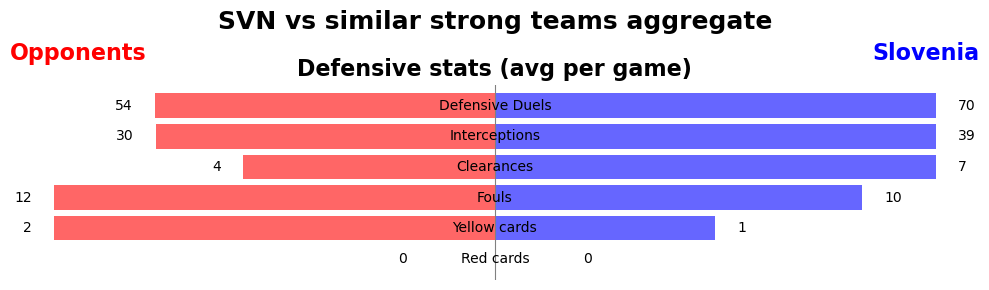

In [128]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)

team2_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team2)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team2, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team2, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team2, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

team1_data = {'Defensive Duels': int(df_events[(df_events["groundDuel.duelType"] == "defensive_duel") & (df_events["team.name"] == team1)]["groundDuel.relatedDuelId"].notna().sum() / num_matches),
            'Interceptions': int(team_type_counts.loc[team1, 'interception'] / num_matches),
            'Clearances': int(team_type_counts.loc[team1, 'clearance'] / num_matches),
            'Fouls': int(team_type_counts.loc[team1, 'infraction'] / num_matches),
            'Yellow cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches),
            'Red cards': int(df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches),
            }

perc_categories = []

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive stats (avg per game)', team1_color='blue', team2_color='red',saveplt=True, savepath=f'plots/4-defense/defense_statistics_SVN_vs_similar.png')

### Defensive style and efficiency

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


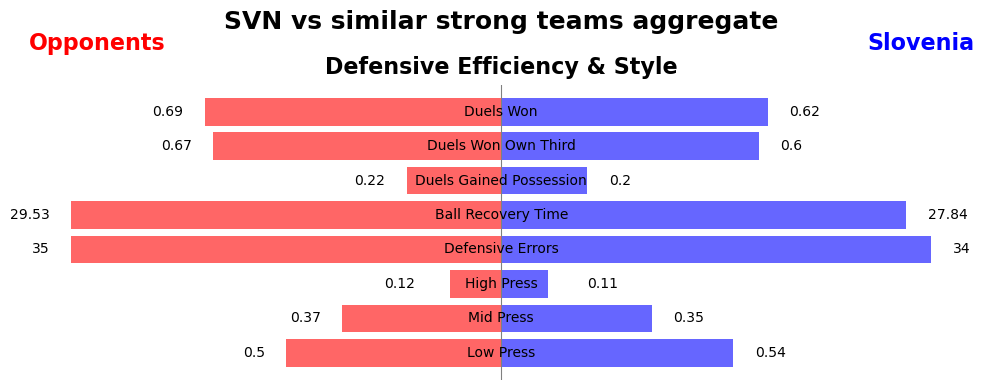

In [129]:
# Use the function to calculate stats for Denmark and Slovenia
team2_data = calculate_defensive_efficiency(team2, team1, num_matches=num_matches)
team1_data = calculate_defensive_efficiency(team1, team2, num_matches=num_matches)

perc_categories = ["Duels Won", "Duels Won Own Third", "Duels Gained Possession", "High Press", "Mid Press", "Low Press"]

plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title,
                    subtitle='Defensive Efficiency & Style', team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/4-defense/defensive_efficiency_style_SVN_vs_similar.png')